In [1]:
import albumentations as A
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [2]:
def visualize(image, bounding_boxes, labels, labels_dict):
    # Draw bounding boxes on image
    curr = bounding_boxes[0]
    labels_list = []
    i = 0
    for x_min, y_min, width, height in bounding_boxes:
        # If we've changed object
        label = labels[i]
        i += 1
        if curr[0] != x_min and curr[1] != y_min:
            cv2.rectangle(image, (curr[0], curr[1]), (curr[0] + curr[2], curr[1] + curr[3]), (255, 0, 0), 2)
            cv2.putText(image, " ".join(labels_list), (curr[0], curr[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            curr = (x_min, y_min, width, height)
            labels_list = [str(labels_dict[label])]
        # Otherwise, add label to list of current image
        else:
            labels_list.append(str(labels_dict[label]))

    # Mark last image
    cv2.rectangle(image, (curr[0], curr[1]), (curr[0] + curr[2], curr[1] + curr[3]), (255, 0, 0), 2)
    cv2.putText(image, " ".join(labels_list), (curr[0], curr[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(image)


def get_boxes_and_labels(image, labels_path):
    image_height, image_width = temp_image.shape[:2]
    bounding_boxes = []
    used_labels = []
    with open(labels_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            label = int(parts[0])
            x_center, y_center, width, height = map(float, parts[1:])
            
            # Convert normalized coordinates to pixel values
            x_center = int(x_center * image_width)
            y_center = int(y_center * image_height)
            width = int(width * image_width)
            height = int(height * image_height)
            
            # Calculate top-left corner of bounding box
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
    
            # Store bounding box and label
            bounding_boxes.append((x_min, y_min, width, height))
            used_labels.append(label)

    return bounding_boxes, used_labels

In [3]:
# Get image
image = cv2.imread('/kaggle/input/forge-4000/4000_all_labels/train/images/0.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# To visualize original image
temp_image = cv2.imread('/kaggle/input/forge-4000/4000_all_labels/train/images/0.png')
temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)

# Get labels.txt path
labels_path = '/kaggle/input/forge-4000/4000_all_labels/train/labels/0.txt'

In [4]:
# Get dict of all labels
with open("/kaggle/input/forge-4000/4000_all_labels/data.yaml", "r") as file:
    data = yaml.safe_load(file)

labels = data['names']  # list of bounding boxes and labels
labels_dict = {}
for i, label in enumerate(labels):
    labels_dict[i] = label

In [5]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Blur(p=0.5),
    A.CLAHE(p=0.5),
    A.Rotate(p=0.5),
    A.HueSaturationValue(p=0.5)
], bbox_params=A.BboxParams(format='coco', label_fields = ['labels']))

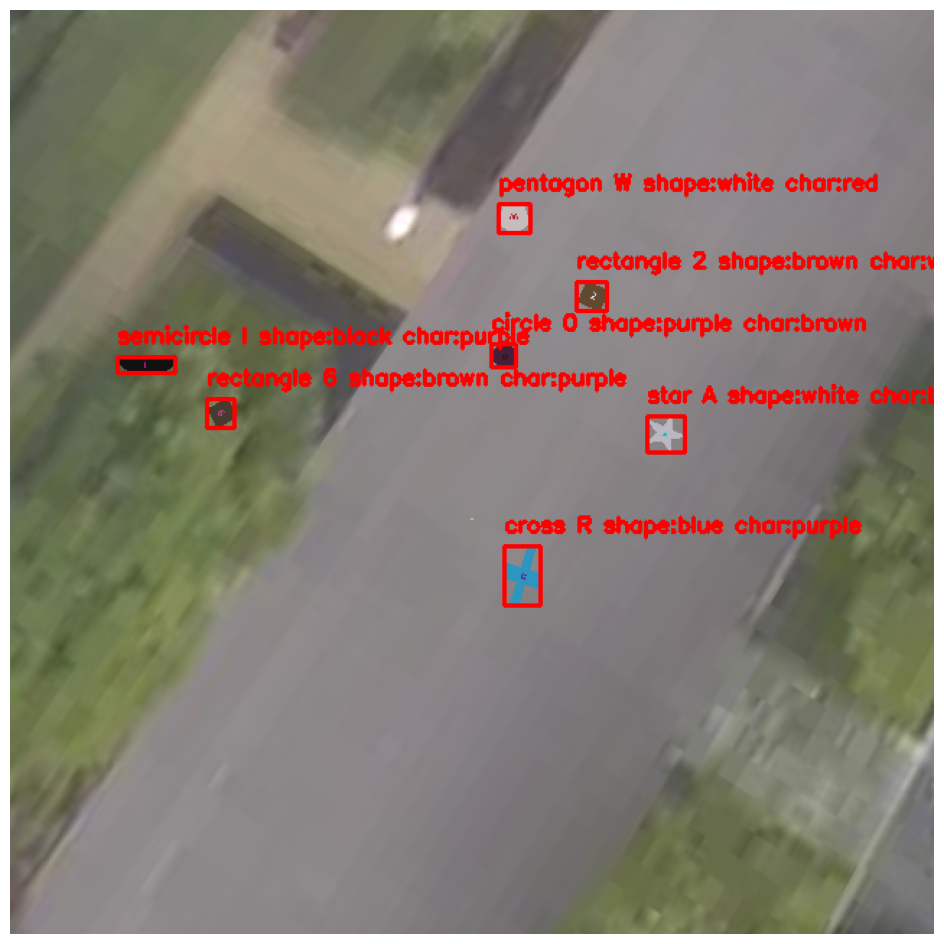

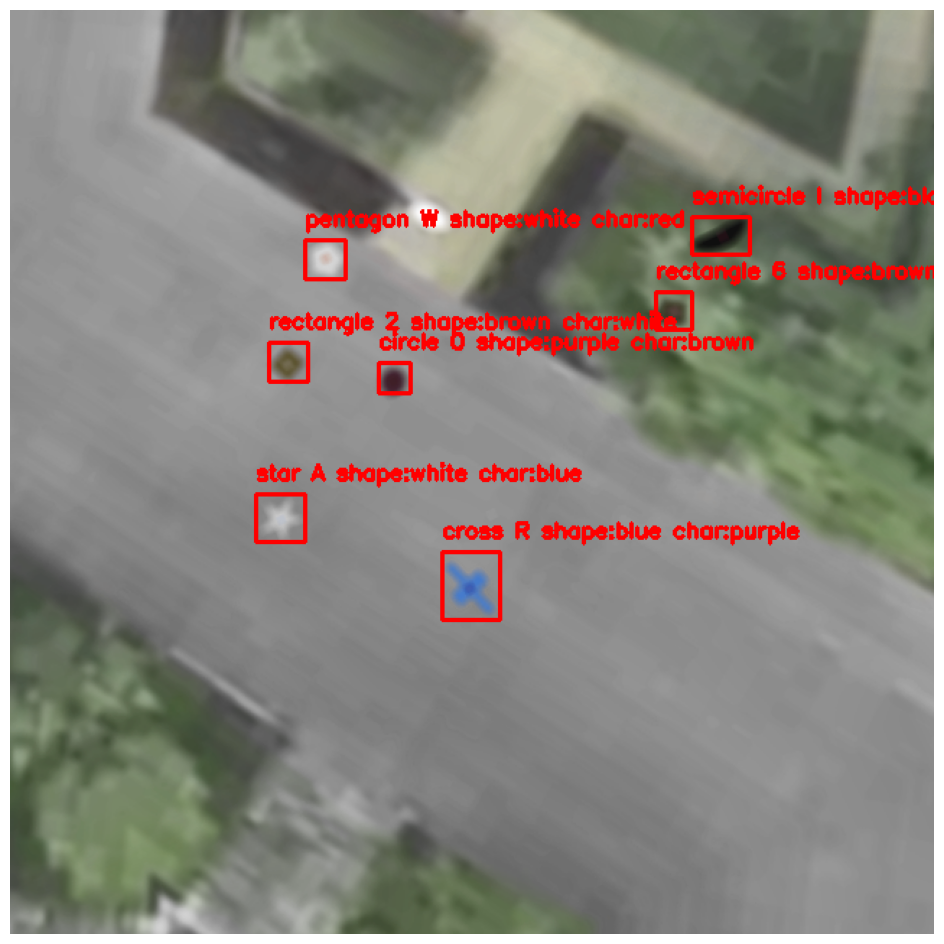

In [6]:
bounding_boxes, used_labels = get_boxes_and_labels(temp_image, labels_path)

visualize(temp_image, bounding_boxes, used_labels, labels_dict)

# Augment an image
transformed = transform(image=image, bboxes=bounding_boxes, labels=used_labels)
int_transformed_bounding_boxes = [[int(value) for value in sublist] for sublist in transformed['bboxes']]
visualize(transformed['image'], int_transformed_bounding_boxes, transformed['labels'], labels_dict)